## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re

import seaborn as sns
import numpy as np
import math

from requests_html import HTMLSession
import random
from time import sleep

from fuzzywuzzy import fuzz
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Exploration du dataset

In [2]:
car_data = pd.read_csv("Data_cars.csv")

In [3]:
car_data.shape

(166695, 9)

Pour les phases de tests, on ne prend qu'une partie de dataset

In [4]:
# car_data = car_data[0:20000]

In [5]:
print(car_data.columns)
car_data.head(10)

Index(['Price', 'Make', 'Model', 'Model_year', 'Mileage', 'Fuel', 'Gearbox',
       'Online', 'Description'],
      dtype='object')


,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


In [6]:
car_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,166695.0,19333.694580,16420.342104,1.0,11280.0,15774.0,22707.5,1486500.0
Model_year,166695.0,2014.605387,8.304980,1900.0,2013.0,2016.0,2017.0,5018.0


In [7]:
count_nan = len(car_data) - car_data.count()
count_nan

Price          0
Make           0
Model          0
Model_year     0
Mileage        0
Fuel           0
Gearbox        0
Online         0
Description    0
dtype: int64

## Features engineering

In [8]:
df = pd.DataFrame(columns = ["Make"])

### Marque

In [9]:
df["Make"] = car_data["Make"]

#### Regroupement de marques et leurs filliales

In [10]:
temp = df['Make'].unique()
np.sort(temp)

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'BURBY S', 'CADILLAC', 'CATERHAM', 'CHATENET', 'CHEVROLET',
       'CHRYSLER', 'CITROEN', 'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL',
       'DODGE', 'DONKERVOORT', 'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD',
       'GRECAV', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI',
       'INTERMECCANICA', 'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA',
       'LAMBORGHINI', 'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS',
       'MASERATI', 'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES',
       'MERCEDES-AMG', 'MG', 'MIA ELECTRIC', 'MICROCAR', 'MINI',
       'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN', 'OLDSMOBILE',
       'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'RILEY',
       'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SECMA', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 

BMW-ALPINA et ALPINA sont des marques identiques, tout comme PEUGEOT et DANGEL

In [11]:
df["Make"] = df["Make"].apply(lambda x: 'BMW-ALPINA' if x == 'ALPINA' else x)

In [12]:
df["Make"] = df["Make"].apply(lambda x: 'PEUGEOT' if x == 'DANGEL' else x)

In [13]:
temp = df['Make'].unique()
np.sort(temp)

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINE', 'ASTON MARTIN',
       'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI', 'BELLIER',
       'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI', 'BURBY S',
       'CADILLAC', 'CATERHAM', 'CHATENET', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DACIA', 'DAEWOO', 'DAIHATSU', 'DODGE', 'DONKERVOORT',
       'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD', 'GRECAV', 'HONDA',
       'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI', 'INTERMECCANICA',
       'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA', 'LAMBORGHINI',
       'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS', 'MASERATI',
       'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES', 'MERCEDES-AMG', 'MG',
       'MIA ELECTRIC', 'MICROCAR', 'MINI', 'MITSUBISHI', 'MORGAN',
       'MPM MOTORS', 'NISSAN', 'OLDSMOBILE', 'OPEL', 'PACKARD', 'PEUGEOT',
       'PORSCHE', 'RENAULT', 'RILEY', 'ROLLS ROYCE', 'ROVER', 'SAAB',
       'SEAT', 'SECMA', 'SHELBY', 'SIMCA', 'SKODA', 'SMART', 'SSANGYONG',
       'SUBARU

#### Regroupement des marques avec peu de voiture en categorie

In [14]:
df['Make_v2'] = df['Make']

In [15]:
df['Make_v2'].value_counts()[-40:]

SAAB              20
MORGAN            18
ROVER             17
TRIUMPH           17
AIXAM             14
MICROCAR          11
LIGIER            10
MCLAREN           10
DAIHATSU           8
HUMMER             8
AUSTIN             7
AUSTIN HEALEY      6
BMW-ALPINA         6
CHATENET           4
PACKARD            3
LADA               3
DAEWOO             3
OLDSMOBILE         2
BOLLORE            2
MIA ELECTRIC       2
ALPINE             2
DONKERVOORT        2
SUNBEAM            1
CATERHAM           1
BUGATTI            1
AUTOBIANCHI        1
FISKER             1
SIMCA              1
MATRA              1
AC                 1
INTERMECCANICA     1
SHELBY             1
BURBY S            1
SECMA              1
JIAYUAN            1
BELLIER            1
MPM MOTORS         1
RILEY              1
INNOCENTI          1
GRECAV             1
Name: Make_v2, dtype: int64

Création de listes de marques en fonction de leur gamme de voiture

In [16]:
high = ["RILEY","AC","MPM MOTORS","BUGATTI","INTERMECCANICA","MATRA","CATERHAM","SHELBY","FISKER","SUNBEAM",
        "DONKERVOORT","ALPINE","OLDSMOBILE","AUSTIN HEALEY","BMW-ALPINA","AUSTIN","HUMMER","MCLAREN","TRIUMPH",
        "ROVER","MORGAN","TESLA","ROLLS ROYCE","LOTUS","CADILLAC","MERCEDES-AMG","LAMBORGHINI","DODGE","BENTLEY",
        "ASTON MARTIN","CHRYSLER"]

medium = ["SECMA","BURBY S","SIMCA","MIA ELECTRIC","BOLLORE","DAEWOO","PACKARD","LADA","DAIHATSU","SAAB","MG",
          "SSANGYONG"]

low = ["AUTOBIANCHI","BELLIER","GRECAV","INNOCENTI","JIAYUAN"]

sans_permis = ["LIGIER","MICROCAR","CHATENET","AIXAM"]

In [17]:
df["Make_v2"] = df["Make_v2"].apply(lambda x: 'HIGH' if x in high else x)
df["Make_v2"] = df["Make_v2"].apply(lambda x: 'MEDIUM' if x in medium else x)
df["Make_v2"] = df["Make_v2"].apply(lambda x: 'LOW' if x in low else x)
df["Make_v2"] = df["Make_v2"].apply(lambda x: 'SANS PERMIS' if x in sans_permis else x)

In [18]:
df['Make_v2'].value_counts()[-20:]

SUZUKI         1045
ALFA ROMEO     1043
JEEP            930
MAZDA           738
JAGUAR          690
SMART           684
HONDA           667
HIGH            531
LEXUS           476
CHEVROLET       395
MITSUBISHI      389
INFINITI        269
MASERATI        181
ABARTH          177
FERRARI         167
MEDIUM          123
SUBARU          117
LANCIA          111
SANS PERMIS      39
LOW               5
Name: Make_v2, dtype: int64

### Modèle

In [19]:
df["Model"] = car_data["Model"]

#### Modèle détaillé (description)

In [20]:
df["Model_Det"] = car_data["Description"].apply(lambda x: x.split('modele: ')[1].split(', version:')[0].upper())

In [21]:
df["Model_Det"] = [df.iloc[i]["Model"] if x=="" else x for i, x in enumerate(df["Model_Det"])]

In [22]:
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(2E GENERATION)", "2"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(3E GENERATION)", "3"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(4E GENERATION)", "4"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(5E GENERATION)", "5"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(6E GENERATION)", "6"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(7E GENERATION)", "7"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(8E GENERATION)", "8"))
df["Model_Det"] = df["Model_Det"].apply(lambda x: x.replace("(9E GENERATION)", "9"))

In [23]:
df['Model_Det'].unique().size

1819

### Année de construction / age / date de l'offre

#### Année de construction

In [24]:
df["Model_year"] = car_data["Model_year"]

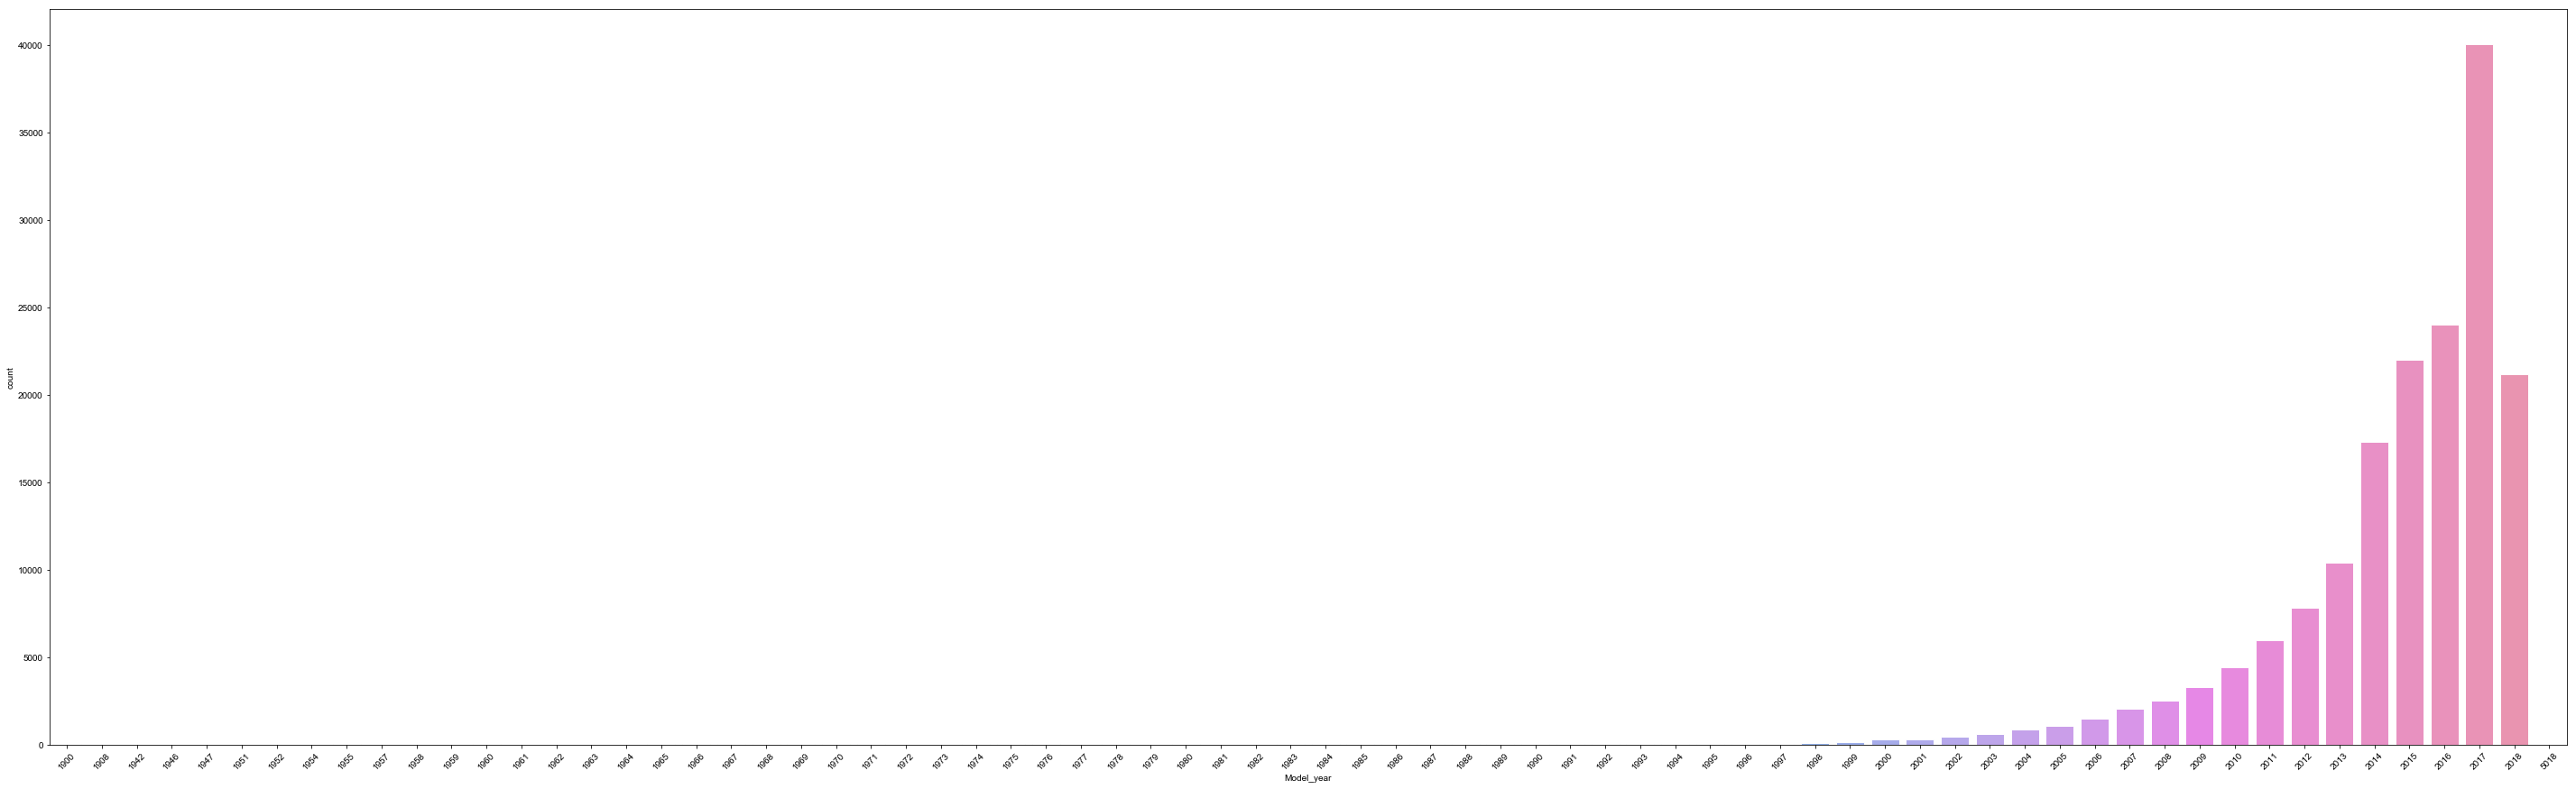

In [25]:
plt.figure(figsize=(50, 15))
plt.xticks(rotation=45)
sns.set(font_scale=2.5)
ax = sns.countplot(data=df, x = 'Model_year')

On supprime les valeurs sous 1990 et au dessus de 2020

In [26]:
df.shape

(166695, 5)

In [27]:
df = df[df["Model_year"] < 2020]
df = df[df["Model_year"] > 1990]

car_data = car_data[car_data["Model_year"] < 2020]
car_data = car_data[car_data["Model_year"] > 1990]

In [28]:
df.shape

(166378, 5)

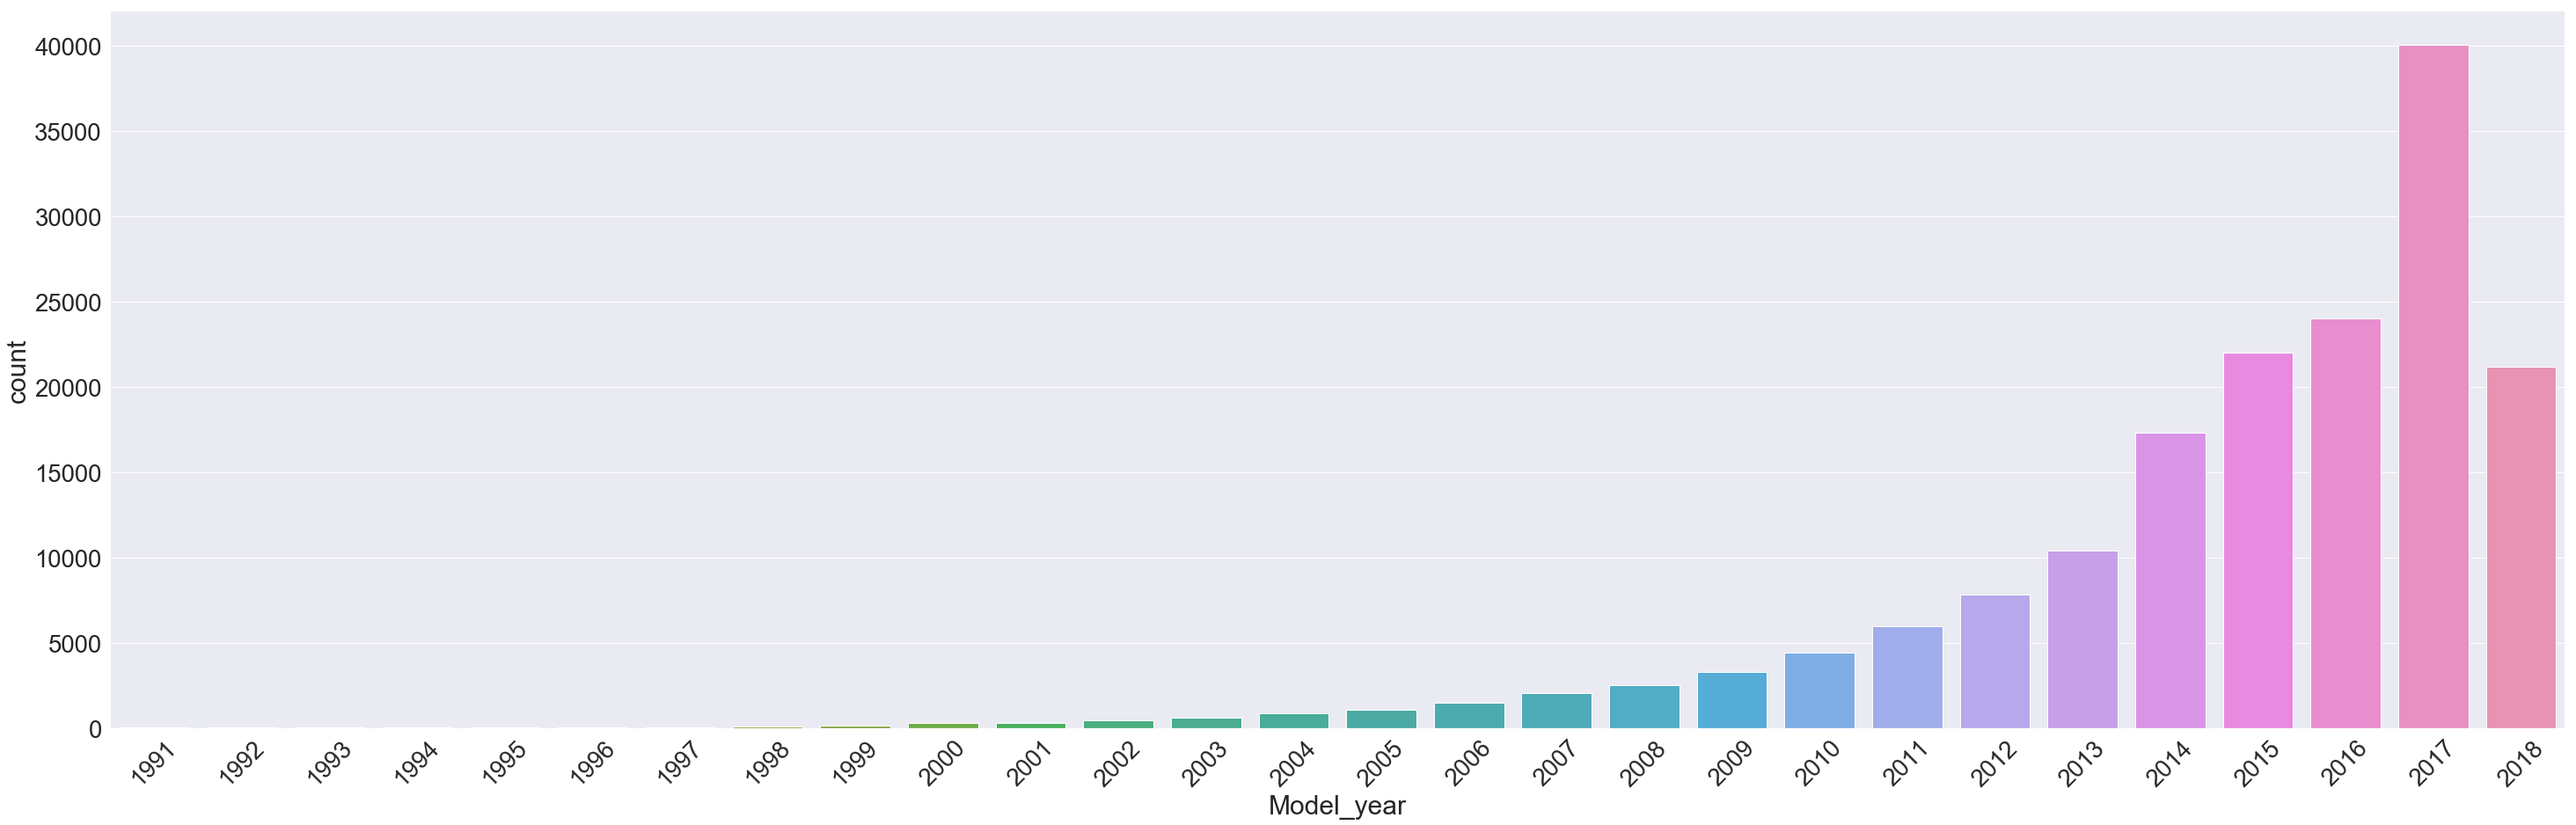

In [29]:
plt.figure(figsize=(50, 15))
plt.xticks(rotation=45)
sns.set(font_scale=2.5)
ax = sns.countplot(data=df, x = 'Model_year')

#### Date de l'offre

In [30]:
df["Online"] = car_data["Online"]

In [31]:
df["Online"] = df["Online"].apply(lambda x: x[0:10])

#### Age de la voiture

In [32]:
df["Age"] = [int(x[6:10]) - int(df.iloc[i]["Model_year"]) for i, x in enumerate(df["Online"])]

### Kilométrage et Usure

#### Kilométrage

In [33]:
df["Mileage"] = car_data["Mileage"]

In [34]:
df["Mileage"] = df["Mileage"].apply(lambda x: int(x[:-5]))

#### Usure

Usure : Kilométrage / Année

In [35]:
df["Usure"] = [int(df.iloc[i]["Mileage"] / x) 
               if x != 0
               else int(df.iloc[i]["Mileage"])
               for i, x in enumerate(df["Age"])]

In [36]:
df.head()

,Make,Make_v2,Model,Model_Det,Model_year,Online,Age,Mileage,Usure
0,PEUGEOT,PEUGEOT,308,308 2,2014,06/07/2018,4,94341,23585
1,BMW,BMW,X6,X6 F16,2015,03/04/2018,3,39051,13017
2,AUDI,AUDI,RS6,RS6 3 AVANT,2014,30/07/2018,4,75381,18845
3,FORD,FORD,KA,KA,2007,09/07/2018,11,92282,8389
4,FIAT,FIAT,TIPO,TIPO 2 SW,2018,19/05/2018,0,10,10


### Fuel

In [37]:
df["Fuel"] = car_data["Fuel"]

In [38]:
df["Fuel"].value_counts()

Diesel                              109431
Essence                              53092
Hybride essence électrique            2724
Electrique                             703
Hybride diesel électrique              310
Bicarburation essence GPL               96
Bicarburation essence bioéthanol        21
Bicarburation essence GNV                1
Name: Fuel, dtype: int64

In [39]:
df["Diesel"] = df["Fuel"].apply(lambda x: 1 if x == "Diesel" else 0)
df["Essence"] = df["Fuel"].apply(lambda x: 1 if x == "Essence" else 0)
df["Other_fuel"] = df["Fuel"].apply(lambda x: 1 if x != "Essence" and x != "Diesel" else 0)

In [40]:
df.head(5)

,Make,Make_v2,Model,Model_Det,Model_year,Online,Age,Mileage,Usure,Fuel,Diesel,Essence,Other_fuel
0,PEUGEOT,PEUGEOT,308,308 2,2014,06/07/2018,4,94341,23585,Diesel,1,0,0
1,BMW,BMW,X6,X6 F16,2015,03/04/2018,3,39051,13017,Diesel,1,0,0
2,AUDI,AUDI,RS6,RS6 3 AVANT,2014,30/07/2018,4,75381,18845,Essence,0,1,0
3,FORD,FORD,KA,KA,2007,09/07/2018,11,92282,8389,Essence,0,1,0
4,FIAT,FIAT,TIPO,TIPO 2 SW,2018,19/05/2018,0,10,10,Essence,0,1,0


### Gearbox

In [41]:
df["Gearbox"] = car_data["Gearbox"]

In [42]:
df["Gearbox"].value_counts()

mécanique      112766
automatique     53612
Name: Gearbox, dtype: int64

In [43]:
df["Mecanique"] = df["Gearbox"].apply(lambda x: 1 if x == "mécanique" else 0)
df["Automatique"] = df["Gearbox"].apply(lambda x: 1 if x == "automatique" else 0)

In [44]:
df.head(5)

,Make,Make_v2,Model,Model_Det,Model_year,Online,Age,Mileage,Usure,Fuel,Diesel,Essence,Other_fuel,Gearbox,Mecanique,Automatique
0,PEUGEOT,PEUGEOT,308,308 2,2014,06/07/2018,4,94341,23585,Diesel,1,0,0,mécanique,1,0
1,BMW,BMW,X6,X6 F16,2015,03/04/2018,3,39051,13017,Diesel,1,0,0,automatique,0,1
2,AUDI,AUDI,RS6,RS6 3 AVANT,2014,30/07/2018,4,75381,18845,Essence,0,1,0,automatique,0,1
3,FORD,FORD,KA,KA,2007,09/07/2018,11,92282,8389,Essence,0,1,0,mécanique,1,0
4,FIAT,FIAT,TIPO,TIPO 2 SW,2018,19/05/2018,0,10,10,Essence,0,1,0,mécanique,1,0


### Traitement description

In [45]:
car_data.iloc[0]['Description']

"modele: 308 (2E GENERATION), version: 1.6 HDI FAP 92CH BUSINESS 5P, puissance_fiscale: 4, portes: 5.0, options: banquette arrière 3 places;volant cuir;cache bagages;airbag frontal;banquette 1/3 - 2/3;sièges rang 2 rabattables à plat;vitres teintées;boucliers av et ar couleur caisse;phares av. de jour à LED;airbags rideaux;rétroviseurs électriques et dégivrants;siège conducteur avec réglage lombaire;vitres électriques;feux de freinage d'urgence;banquette rabattable;feux ar. à LED;AFU;contrôle de pression des pneus;airbags front. + lat.;blanc banquise;lampes de lecture à l'arrière;sièges réglables en hauteur;alarme d'oubli d'extinction des feux;EBD;volant sport;température extérieure;système audio;becquet;feux automatiques;fermeture électrique;ESP;fermeture électrique automatique;bacs de portes avant;anti patinage;accoudoir central avant;commandes du système audio au volant;fixations ISOFIX;poches d'aumonières;lampes de lecture à l'avant;lunette arrière dégivrante;essuie-glace arrière;o

### - Version

In [46]:
df["Version"] = car_data["Description"].apply(lambda x: x.split('version: ')[1].split(', puissance_fiscale:')[0].upper())

In [47]:
df["Version"].head(10)

0                         1.6 HDI FAP 92CH BUSINESS 5P
1                     (F16) XDRIVE30D 258 M SPORT BVA8
2             III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC
3                                           1.3 70 FUN
4                                     II SW 1.4 95 POP
5                (F25) XDRIVE35D 313 SPORT DESIGN BVA8
6    II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...
7                 IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC
8                    II 1.6 TDCI 115 FAP TITANIUM BVM6
9                   (W205) 63 AMG S SPEEDSHIFT MCT AMG
Name: Version, dtype: object

In [48]:
df["Version_temp"] = df["Version"]

#### Numéro de génération

In [49]:
#Générations standard
vers = {"II": 2, "III": 3, "IV": 4, "V": 5, "VI": 6, "VII": 7, "VIII": 8, "IX": 9, "X": 10,
        "(2)": 2, "(3)": 3, "(4)": 4, "(5)": 5, "(6)": 6, "(7)": 7, "(8)": 8, "(9)": 9, "(10)": 10}

#Génération BMW.....
vers2 = {"(E28)": 2, "(E30)": 2, "(E32)": 2, "(E63)": 2, "(E64)": 2, "(E70)": 2, "(E89)": 2, "(F16)": 2,
         "(X6)": 2, "(F20)": 2,"(F21)": 2, "(F25)": 2, "(F48)": 2, "(E34)": 3, "(E36)": 3, "(E38)": 3, 
         "(F06)": 3, "(F12)": 3, "(F13)": 3, "(F15)": 3, "(F52)": 3, "(E39)": 4, "(E46)": 4, "(E65)": 4, 
         "(E66)": 4, "(E67)": 4, "(E68)": 4, "(E60)": 5, "(E61)": 5, "(E90)": 5, "(E91)": 5, "(E92)": 5, 
         "(E93)": 5, "(F01)": 5, "(F02)": 5, "(F03)": 5, "(F04)": 5, "(F07)": 6, "(F10)": 6, "(F11)": 6, 
         "(F18)": 6, "(F30)": 6, ("F31"): 6, ("F34"): 6, ("F35"): 6, ("G11"): 6, ("G12"): 6, ("G30"): 7,
         "(G31)": 7}

In [50]:
df["Génération"] = df["Version_temp"].apply(lambda x: vers[x.split(" ")[0]] if x.split(" ")[0] in vers else 1)

In [51]:
df["Génération"] = [vers2[x.split(" ")[0]] 
               if x.split(" ")[0] in vers2
               else df.iloc[i]["Génération"]
               for i, x in enumerate(df["Version_temp"])]

In [52]:
df["Version_temp"] = df["Version_temp"].apply(lambda x: ' '.join(x.split(" ")[1:]) if x.split(" ")[0] in vers or x.split(" ")[0] in vers2 else x)

In [53]:
df[["Make","Model", "Version", "Version_temp", "Génération"]].head(10)

,Make,Model,Version,Version_temp,Génération
0,PEUGEOT,308,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,1
1,BMW,X6,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,2
2,AUDI,RS6,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,3
3,FORD,KA,1.3 70 FUN,1.3 70 FUN,1
4,FIAT,TIPO,II SW 1.4 95 POP,SW 1.4 95 POP,2
5,BMW,X3,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,2
6,AUDI,A3,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,(2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE QU...,2
7,RENAULT,MEGANE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,ESTATE 1.5 DCI 110 ENERGY ZEN EDC,4
8,FORD,C-MAX,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,2
9,MERCEDES,CLASSE C,(W205) 63 AMG S SPEEDSHIFT MCT AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,1


In [54]:
df["Version_temp"] = df["Version_temp"].apply(lambda x: ' '.join(x.split(" ")[1:]) if "(" in x.split(" ")[0] and ")" in x.split(" ")[0] else x)

In [55]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Génération"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Génération
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,1
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,2
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,3
3,FORD,KA,KA,1.3 70 FUN,1.3 70 FUN,1
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,SW 1.4 95 POP,2
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,2
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE QUATTRO,2
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,ESTATE 1.5 DCI 110 ENERGY ZEN EDC,4
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,2
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,63 AMG S SPEEDSHIFT MCT AMG,1


#### Modèle special

In [56]:
df["Version_adj"] = df["Version_temp"].apply(lambda x: x.split(" ")[0] if x.split(" ")[0].isalpha() else None)

In [57]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Version_adj"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Version_adj
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,None
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,None
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,AVANT
3,FORD,KA,KA,1.3 70 FUN,1.3 70 FUN,None
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,SW 1.4 95 POP,SW
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,None
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE QUATTRO,SPORTBACK
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,ESTATE 1.5 DCI 110 ENERGY ZEN EDC,ESTATE
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,None
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,63 AMG S SPEEDSHIFT MCT AMG,None


In [58]:
df["Version_adj"].value_counts()[0:20]

SW           3627
SPORTBACK    2836
ESTATE       2381
COUPE        1745
CABRIOLET    1421
STEPWAY       959
AVANT         869
GRAN          748
TOURING       729
COOPER        686
HDI           680
DCI           442
COMBI         381
BLUEHDI       360
C             359
ACTIVE        357
SHOOTING      327
CC            324
CLUBMAN       313
TOURER        296
Name: Version_adj, dtype: int64

In [59]:
df['Version_adj'].unique().size

418

In [60]:
df["Version_temp"] = df["Version_temp"].apply(lambda x: ' '.join(x.split(" ")[1:]) if x.split(" ")[0].isalpha() else x)

In [61]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Version_adj"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Version_adj
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,None
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,None
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,4.0 TFSI 560 QUATTRO TIPTRONIC,AVANT
3,FORD,KA,KA,1.3 70 FUN,1.3 70 FUN,None
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,1.4 95 POP,SW
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,None
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,2.0 TDI 140 7CV AMBITION LUXE QUATTRO,SPORTBACK
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,1.5 DCI 110 ENERGY ZEN EDC,ESTATE
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,None
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,63 AMG S SPEEDSHIFT MCT AMG,None


#### Cylindré

In [62]:
def test_float(x):
    try:
        return float(x)
    except ValueError:
        return x
    
def test_int(x):
    try:
        return int(x)
    except ValueError:
        return x   

def int_to_float(x):
    if isinstance(x, int) :
        x = [str(i) for i in str(x)]
        if len(x) == 3 :
            del x[-1]
            x.insert(-1, ".")
            x = ''.join(x)
            return float(x)
        else :
            x.insert(-1, ".")
            x = ''.join(x)
            return float(x)
        
def extract_int(x):
    x = [str(i) for i in str(x) if i.isdigit()]
    if len(x) > 0 :
        x = int(''.join(x))
        return x
    else :
        return 0.0

On extrait en premier les float

In [63]:
df["Cylindre"] = df["Version_temp"].apply(lambda x: x.split(" ")[0] if isinstance(test_float(x.split(" ")[0]), float) and "." in x.split(" ")[0] else None)

On transforme ensuite les int en cylindrés

In [64]:
df["Cylindre"] = [int_to_float(int(x.split(" ")[0]))
                   if isinstance(test_int(x.split(" ")[0]), int)
                   else df.iloc[i]["Cylindre"]
                   for i, x in enumerate(df["Version_temp"])]

In [65]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Cylindre"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Cylindre
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,1.6
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,None
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,4.0 TFSI 560 QUATTRO TIPTRONIC,4.0
3,FORD,KA,KA,1.3 70 FUN,1.3 70 FUN,1.3
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,1.4 95 POP,1.4
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,None
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,2.0 TDI 140 7CV AMBITION LUXE QUATTRO,2.0
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,1.5 DCI 110 ENERGY ZEN EDC,1.5
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,1.6
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,63 AMG S SPEEDSHIFT MCT AMG,6.3


On extrait les cylindrés dans les valeurs alphanumériques

In [66]:
df["Cylindre"] = [int_to_float(extract_int(x.split(" ")[0]))
                   if not x.split(" ")[0].isalpha() and not df.iloc[i]["Cylindre"]
                   else df.iloc[i]["Cylindre"]
                   for i, x in enumerate(df["Version_temp"])]

In [67]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Cylindre"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Cylindre
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,1.6 HDI FAP 92CH BUSINESS 5P,1.6
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,XDRIVE30D 258 M SPORT BVA8,3
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,4.0 TFSI 560 QUATTRO TIPTRONIC,4.0
3,FORD,KA,KA,1.3 70 FUN,1.3 70 FUN,1.3
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,1.4 95 POP,1.4
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,XDRIVE35D 313 SPORT DESIGN BVA8,3.5
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,2.0 TDI 140 7CV AMBITION LUXE QUATTRO,2.0
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,1.5 DCI 110 ENERGY ZEN EDC,1.5
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6 TDCI 115 FAP TITANIUM BVM6,1.6
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,63 AMG S SPEEDSHIFT MCT AMG,6.3


On supprime tout ce qui n'est pas alpha

In [68]:
df["Version_temp"] = df["Version_temp"].apply(lambda x: ' '.join(x.split(" ")[1:]) if not x.split(" ")[0].isalpha() else x)

In [69]:
df["Cylindre"] = df["Cylindre"].apply(lambda x: float(x) if x else None)

In [70]:
df[["Make", "Model", "Model_Det", "Version", "Version_temp", "Version_adj", "Cylindre"]].head(10)

,Make,Model,Model_Det,Version,Version_temp,Version_adj,Cylindre
0,PEUGEOT,308,308 2,1.6 HDI FAP 92CH BUSINESS 5P,HDI FAP 92CH BUSINESS 5P,None,1.6
1,BMW,X6,X6 F16,(F16) XDRIVE30D 258 M SPORT BVA8,258 M SPORT BVA8,None,3.0
2,AUDI,RS6,RS6 3 AVANT,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,TFSI 560 QUATTRO TIPTRONIC,AVANT,4.0
3,FORD,KA,KA,1.3 70 FUN,70 FUN,None,1.3
4,FIAT,TIPO,TIPO 2 SW,II SW 1.4 95 POP,95 POP,SW,1.4
5,BMW,X3,X3 F25,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,313 SPORT DESIGN BVA8,None,3.5
6,AUDI,A3,A3 2 SPORTBACK,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,TDI 140 7CV AMBITION LUXE QUATTRO,SPORTBACK,2.0
7,RENAULT,MEGANE,MEGANE 4 ESTATE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,DCI 110 ENERGY ZEN EDC,ESTATE,1.5
8,FORD,C-MAX,C-MAX 2,II 1.6 TDCI 115 FAP TITANIUM BVM6,TDCI 115 FAP TITANIUM BVM6,None,1.6
9,MERCEDES,CLASSE C,CLASSE C 4 AMG,(W205) 63 AMG S SPEEDSHIFT MCT AMG,AMG S SPEEDSHIFT MCT AMG,None,6.3


% de cylindré non trouvé

In [71]:
print(df["Cylindre"].isnull().sum()/df["Cylindre"].count()*100)

3.693316381223045


#### Chevaux

In [72]:
def extract_int_v2(x):
    x = [str(i) for i in str(x) if i.isdigit()]
    if x :
        try:
            return int(''.join(x))
        except:
            pass

def extract_cv(x):
    x = x.split(" ")
    final = []
    for i, y in enumerate(x):
        if not y.isalpha():
            final.append(extract_int_v2(y))
    
    final = [x for x in final if len(str(x)) > 1]
    
    if len(final) > 0 :
        if final[0] :
            if final[0] > 9 :
                return int(final[0])
            else :
                return None
        else :
            return None    
    else :
        return None

In [73]:
df["Chevaux"] = df["Version_temp"].apply(lambda x: extract_cv(x))

In [74]:
df[["Make", "Model", "Version", "Cylindre", "Chevaux"]].head(20)

,Make,Model,Version,Cylindre,Chevaux
0,PEUGEOT,308,1.6 HDI FAP 92CH BUSINESS 5P,1.6,92.0
1,BMW,X6,(F16) XDRIVE30D 258 M SPORT BVA8,3.0,258.0
2,AUDI,RS6,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,4.0,560.0
3,FORD,KA,1.3 70 FUN,1.3,70.0
4,FIAT,TIPO,II SW 1.4 95 POP,1.4,95.0
5,BMW,X3,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,3.5,313.0
6,AUDI,A3,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,2.0,140.0
7,RENAULT,MEGANE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,1.5,110.0
8,FORD,C-MAX,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6,115.0
9,MERCEDES,CLASSE C,(W205) 63 AMG S SPEEDSHIFT MCT AMG,6.3,NaN


% de chevaux non trouvé

In [75]:
print(df["Chevaux"].isnull().sum()/df["Chevaux"].count()*100)

22.82989059016345


#### On complete les cylindres et les chevaux manquant en faisant une approximation

In [76]:
def get_chevaux(cyl):
    temp = []
    for i, x in enumerate(df["Cylindre"]):
        if float(cyl) == x :
            if isinstance(df["Chevaux"].iloc[i], float) and not math.isnan(df["Chevaux"].iloc[i]) :
                temp.append(df["Chevaux"].iloc[i])
    
    if len(temp) > 0:
        return np.median(temp)
    else:
        return None
    
def get_cylindre(che):
    temp = []
    for i, x in enumerate(df["Chevaux"]):
        if float(che) == x :
            if isinstance(df["Cylindre"].iloc[i], float) and not math.isnan(df["Cylindre"].iloc[i]) :
                temp.append(df["Cylindre"].iloc[i])
    
    if len(temp) > 0:
        return np.median(temp)
    else:
        return None

In [77]:
df["Chevaux"] = [
    get_chevaux(df["Cylindre"].iloc[i])
    if math.isnan(x)
    else x
    for i, x in enumerate(df["Chevaux"])
]

In [78]:
df["Cylindre"] = [
    get_chevaux(df["Chevaux"].iloc[i])
    if math.isnan(x)
    else x
    for i, x in enumerate(df["Cylindre"])
]

In [79]:
print(df["Chevaux"].isnull().sum()/df["Chevaux"].count()*100)

0.914660035179232


In [80]:
print(df["Cylindre"].isnull().sum()/df["Cylindre"].count()*100)

3.503020274095318


In [81]:
df[["Make", "Model", "Version", "Cylindre", "Chevaux"]].head(20)

,Make,Model,Version,Cylindre,Chevaux
0,PEUGEOT,308,1.6 HDI FAP 92CH BUSINESS 5P,1.6,92.0
1,BMW,X6,(F16) XDRIVE30D 258 M SPORT BVA8,3.0,258.0
2,AUDI,RS6,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,4.0,560.0
3,FORD,KA,1.3 70 FUN,1.3,70.0
4,FIAT,TIPO,II SW 1.4 95 POP,1.4,95.0
5,BMW,X3,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,3.5,313.0
6,AUDI,A3,II (2) SPORTBACK 2.0 TDI 140 7CV AMBITION LUXE...,2.0,140.0
7,RENAULT,MEGANE,IV ESTATE 1.5 DCI 110 ENERGY ZEN EDC,1.5,110.0
8,FORD,C-MAX,II 1.6 TDCI 115 FAP TITANIUM BVM6,1.6,115.0
9,MERCEDES,CLASSE C,(W205) 63 AMG S SPEEDSHIFT MCT AMG,6.3,286.0


On supprime la colonne Version_temp

In [82]:
df = df.drop(labels=["Version_temp"], axis=1)

In [83]:
df.head(5)

,Make,Make_v2,Model,Model_Det,Model_year,Online,Age,Mileage,Usure,Fuel,...,Essence,Other_fuel,Gearbox,Mecanique,Automatique,Version,Génération,Version_adj,Cylindre,Chevaux
0,PEUGEOT,PEUGEOT,308,308 2,2014,06/07/2018,4,94341,23585,Diesel,...,0,0,mécanique,1,0,1.6 HDI FAP 92CH BUSINESS 5P,1,None,1.6,92.0
1,BMW,BMW,X6,X6 F16,2015,03/04/2018,3,39051,13017,Diesel,...,0,0,automatique,0,1,(F16) XDRIVE30D 258 M SPORT BVA8,2,None,3.0,258.0
2,AUDI,AUDI,RS6,RS6 3 AVANT,2014,30/07/2018,4,75381,18845,Essence,...,1,0,automatique,0,1,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC,3,AVANT,4.0,560.0
3,FORD,FORD,KA,KA,2007,09/07/2018,11,92282,8389,Essence,...,1,0,mécanique,1,0,1.3 70 FUN,1,None,1.3,70.0
4,FIAT,FIAT,TIPO,TIPO 2 SW,2018,19/05/2018,0,10,10,Essence,...,1,0,mécanique,1,0,II SW 1.4 95 POP,2,SW,1.4,95.0


### - Puissance Fiscale

In [84]:
df["Puissance_fisc"] = car_data["Description"].apply(lambda x: x.split('puissance_fiscale: ')[1].split(', portes:')[0].upper())

In [85]:
df[["Make", "Model", "Puissance_fisc"]].head(5)

,Make,Model,Puissance_fisc
0,PEUGEOT,308,4
1,BMW,X6,16
2,AUDI,RS6,47
3,FORD,KA,5
4,FIAT,TIPO,5


### - Portes

In [86]:
df["Portes"] = car_data["Description"].apply(lambda x: x.split('portes: ')[1].split(', options:')[0].upper())

In [87]:
df["Portes"] = df["Portes"].apply(lambda x: '1' if x=='' else int(float(x)))

In [88]:
df["Portes"].value_counts()

5    138785
3     11568
4      8492
2      6244
1      1271
0        16
6         2
Name: Portes, dtype: int64

In [89]:
df[["Make", "Model", "Portes"]].head(5)

,Make,Model,Portes
0,PEUGEOT,308,5
1,BMW,X6,5
2,AUDI,RS6,5
3,FORD,KA,3
4,FIAT,TIPO,5


### - Couleurs

In [90]:
df["Couleur"] = car_data["Description"].apply(lambda x: x.split('couleur: ')[1].upper())

In [91]:
df["Couleur"].unique().size

6686

In [92]:
colors = {"GRIS": "GRIS", "BLANC": "BLANC", "NOIR": "NOIR", "ROUGE": "ROUGE", "BLEU": "BLEU", "MARRON":"MARRON",
          "BEIGE": "BEIGE", "ARGENT": "ARGENT", "PLATINE": "PLATINE", "ORANGE": "ORANGE", "VERT": "VERT",
          "JAUNE": "JAUNE", "BRUN": "BRUN", "VIOLET": "VIOLET", "BLUE": "BLEU", "GLACIER": "BLANC", "SAPHIR": "BLEU",
          "ALPIN": "BLANC"}

In [93]:
def get_color(x):
    x = x.split(" ")
    for w in x:
        if w in colors.keys():
            return colors[w]
    return "OTHER"

In [94]:
df["Couleur"] = df["Couleur"].apply(lambda x: get_color(x))

In [95]:
df[["Make", "Model", "Couleur"]].head(5)

,Make,Model,Couleur
0,PEUGEOT,308,BLANC
1,BMW,X6,OTHER
2,AUDI,RS6,NOIR
3,FORD,KA,JAUNE
4,FIAT,TIPO,BLANC


In [96]:
df["Couleur"].value_counts()

GRIS       56556
BLANC      32854
NOIR       32516
OTHER      15084
BLEU       10439
ROUGE       8134
BEIGE       2506
MARRON      2484
ARGENT      1742
ORANGE       908
BRUN         882
VERT         835
PLATINE      648
JAUNE        445
VIOLET       345
Name: Couleur, dtype: int64

### - Options

In [97]:
df["Options"] = car_data["Description"].apply(lambda x: x.split('options: ')[1].split(', couleur:')[0])

In [98]:
df["Options"] = df["Options"].apply(lambda x: x.split(";"))
df["Options"] = df["Options"].apply(lambda x: [y.upper() for y in x])

In [99]:
df["Options_nb"] = df["Options"].apply(lambda x: len(x))

In [100]:
df[["Make", "Model", "Options", "Options_nb"]].head(5)

,Make,Model,Options,Options_nb
0,PEUGEOT,308,"[BANQUETTE ARRIÈRE 3 PLACES, VOLANT CUIR, CACH...",54
1,BMW,X6,[TRIANGLE DE PRESIGNALISATION ET TROUSSE DE PR...,41
2,AUDI,RS6,"[BANQUETTE ARRIÈRE 3 PLACES, ÉCRAN TACTILE, TÉ...",140
3,FORD,KA,"[DIRECTION ASSISTÉE, JANTES ALU, RÉTROVISEURS ...",8
4,FIAT,TIPO,"[VOLANT ALU & CUIR, BLUETOOTH INCLUT MUSIQUE E...",24


In [101]:
df["Options"] = df["Options"].apply(lambda x: ' '.join(x))

In [102]:
df[["Make", "Model", "Options", "Options_nb"]].head(5)

,Make,Model,Options,Options_nb
0,PEUGEOT,308,BANQUETTE ARRIÈRE 3 PLACES VOLANT CUIR CACHE B...,54
1,BMW,X6,TRIANGLE DE PRESIGNALISATION ET TROUSSE DE PRE...,41
2,AUDI,RS6,BANQUETTE ARRIÈRE 3 PLACES ÉCRAN TACTILE TÉMOI...,140
3,FORD,KA,DIRECTION ASSISTÉE JANTES ALU RÉTROVISEURS ÉLE...,8
4,FIAT,TIPO,VOLANT ALU & CUIR BLUETOOTH INCLUT MUSIQUE EN ...,24


In [103]:
stopwords = set(stopwords.words('french'))

In [104]:
options = []

for x in df["Options"]:
    options.append(x)

In [105]:
cv = CountVectorizer(options, stop_words=stopwords, min_df=90000)

In [106]:
count_vector = cv.fit_transform(options)

In [107]:
count_vector.shape

(166378, 40)

In [108]:
options = {k:"option_"+str(i) for i, k in enumerate(cv.vocabulary_)}
options

{'banquette': 'option_0',
 'volant': 'option_1',
 'cuir': 'option_2',
 'vitres': 'option_3',
 'av': 'option_4',
 'ar': 'option_5',
 'phares': 'option_6',
 'jour': 'option_7',
 'airbags': 'option_8',
 'rétroviseurs': 'option_9',
 'électriques': 'option_10',
 'conducteur': 'option_11',
 'feux': 'option_12',
 'hauteur': 'option_13',
 'système': 'option_14',
 'audio': 'option_15',
 'fermeture': 'option_16',
 'électrique': 'option_17',
 'esp': 'option_18',
 'automatique': 'option_19',
 'avant': 'option_20',
 'fixations': 'option_21',
 'isofix': 'option_22',
 'essuie': 'option_23',
 'ordinateur': 'option_24',
 'bord': 'option_25',
 'climatisation': 'option_26',
 'réglable': 'option_27',
 'abs': 'option_28',
 'prise': 'option_29',
 'alu': 'option_30',
 'projecteurs': 'option_31',
 'antibrouillard': 'option_32',
 'jantes': 'option_33',
 'kit': 'option_34',
 'aide': 'option_35',
 'régulateur': 'option_36',
 'limiteur': 'option_37',
 'vitesse': 'option_38',
 'bluetooth': 'option_39'}

In [109]:
for x in options:
    df[str(options[x])] = 0
    df[str(options[x])] = df["Options"].apply(lambda y: 1 if str(x).upper() in y.split(" ") else 0)

In [110]:
df[["option_0", "option_1", "option_2", "option_3", "option_4", "option_5", "option_6"]].head(5)

,option_0,option_1,option_2,option_3,option_4,option_5,option_6
0,1,1,1,1,1,1,1
1,0,1,1,0,0,0,0
2,1,1,1,1,1,1,1
3,0,0,0,1,0,0,0
4,0,1,1,0,0,0,1


### PRICE

#### Récuperer le prix neuf des voitures

In [111]:
df_prix = pd.read_csv('car_price.csv')

In [112]:
df_prix.shape

(12067, 8)

In [113]:
df_prix.head(10)

,marque_modele,version,energie,boite_vitesse,puis_fisc,date,malus,prix
0,Renault Twizy,Electrique 45 BVA Life (2p.),Électrique,Automatique,1CV,04/2013,n.a.,7540
1,Dacia Logan,1.0 12V Sce 75 Access (4p.),Essence,Manuelle,4CV,06/2019,100,8150
2,Renault Twizy,Electrique 80 BVA Life (2p.),Électrique,Automatique,2CV,04/2013,n.a.,8240
3,Dacia Sandero,1.0i SCe 75 Access (5p.),Essence,Manuelle,4CV,06/2019,100,8290
4,Renault Twizy,Electrique 45 BVA Intens Blanc (2p.),Électrique,Automatique,1CV,07/2015,n.a.,8340
5,Renault Twizy,Electrique 45 BVA Intens Noir (2p.),Électrique,Automatique,1CV,07/2015,n.a.,8340
6,DR DR Zero,1.0i 69 Chrome (5p.),Essence,Manuelle,5CV,03/2016,2205,8900
7,Renault Twizy,Electrique 80 BVA Intens Blanc (2p.),Électrique,Automatique,2CV,07/2015,n.a.,9040
8,Renault Twizy,Electrique 80 BVA Intens Noir (2p.),Électrique,Automatique,2CV,07/2015,n.a.,9040
9,Dacia Logan MCV,1.0i SCe 75 Access (Break),Essence,Manuelle,4CV,06/2019,100,9250


Création d'une colonne marque / modele

In [114]:
df["Marque_modele"] = [x + " " + df["Model"].iloc[i] for i, x in enumerate(df["Make"])]

In [115]:
df[["Make", "Model", "Marque_modele", "Version"]].head(5)

,Make,Model,Marque_modele,Version
0,PEUGEOT,308,PEUGEOT 308,1.6 HDI FAP 92CH BUSINESS 5P
1,BMW,X6,BMW X6,(F16) XDRIVE30D 258 M SPORT BVA8
2,AUDI,RS6,AUDI RS6,III AVANT 4.0 TFSI 560 QUATTRO TIPTRONIC
3,FORD,KA,FORD KA,1.3 70 FUN
4,FIAT,TIPO,FIAT TIPO,II SW 1.4 95 POP


In [116]:
def match_cars(car, vers):
    df_temp = pd.DataFrame(columns = ['marque_modele', 'version', 'energie', 'boite_vitesse', 'puis_fisc', 'date', 'malus', 'prix'])
    for i, x in enumerate(df_prix["marque_modele"]):
        if str(car) == str(x).upper():
            df_temp = df_temp.append(df_prix.iloc[i])
    
    if len(df_temp > 0):
        for i, x in enumerate(df_temp["marque_modele"]):
            if fuzz.ratio(vers.upper(), x.upper()) > 20:
                return df_temp["prix"].iloc[i]
                break
                
        return df_temp["prix"].median()
        
    return None

print(match_cars("RENAULT TWIZY", "Electrique 45 BVA Intens Blanc"))

7540


In [117]:
df["Prix_neuf"] = [match_cars(car, df["Version"].iloc[i])
                   for i, car in enumerate(df["Marque_modele"])]

In [118]:
df["Prix_neuf"].head(5)

0    21650.0
1    85675.0
2        NaN
3        NaN
4    13490.0
Name: Prix_neuf, dtype: float64

In [119]:
print(df["Prix_neuf"].isnull().sum()/df["Prix_neuf"].count()*100)

45.21444655855604


In [120]:
df[["Make", "Model", "Marque_modele", "Prix_neuf"]].head(10)

,Make,Model,Marque_modele,Prix_neuf
0,PEUGEOT,308,PEUGEOT 308,21650.0
1,BMW,X6,BMW X6,85675.0
2,AUDI,RS6,AUDI RS6,NaN
3,FORD,KA,FORD KA,NaN
4,FIAT,TIPO,FIAT TIPO,13490.0
5,BMW,X3,BMW X3,59600.0
6,AUDI,A3,AUDI A3,NaN
7,RENAULT,MEGANE,RENAULT MEGANE,NaN
8,FORD,C-MAX,FORD C-MAX,29550.0
9,MERCEDES,CLASSE C,MERCEDES CLASSE C,39300.0


#### Ajouter le prix de revente

In [121]:
df["Price"] = car_data["Price"]

In [122]:
df.head()

,Make,Make_v2,Model,Model_Det,Model_year,Online,Age,Mileage,Usure,Fuel,...,option_33,option_34,option_35,option_36,option_37,option_38,option_39,Marque_modele,Prix_neuf,Price
0,PEUGEOT,PEUGEOT,308,308 2,2014,06/07/2018,4,94341,23585,Diesel,...,0,0,0,0,0,0,0,PEUGEOT 308,21650.0,11220.0
1,BMW,BMW,X6,X6 F16,2015,03/04/2018,3,39051,13017,Diesel,...,1,1,1,0,0,0,0,BMW X6,85675.0,57526.0
2,AUDI,AUDI,RS6,RS6 3 AVANT,2014,30/07/2018,4,75381,18845,Essence,...,1,1,1,1,1,1,1,AUDI RS6,NaN,80379.0
3,FORD,FORD,KA,KA,2007,09/07/2018,11,92282,8389,Essence,...,1,0,0,0,0,0,0,FORD KA,NaN,2830.0
4,FIAT,FIAT,TIPO,TIPO 2 SW,2018,19/05/2018,0,10,10,Essence,...,0,0,1,0,0,0,1,FIAT TIPO,13490.0,12925.0


On supprime la colonne Marque / Modele

In [123]:
df = df.drop(labels=["Marque_modele"], axis=1)

### Transformation en csv

In [124]:
df.shape

(166378, 68)

In [125]:
df.to_csv(r'final2.csv', index = False)